In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import multiprocessing as mp
import plotly.express as px
import datashader as ds
import datashader.transfer_functions as tf
import vispy.plot as vp

from scipy.io import wavfile
from scipy.signal import correlate
from scipy.fft import ifft, fft, fftfreq, fftshift, ifft2, fft2
from methods import load_file, load_dataframe, plot_signal, cut_signal, plot_cut, corr_f, split_array, mean_corr, parallel_corr_f, find_delta_time
from scipy.signal import hilbert
from scipy.signal import hilbert, find_peaks
from scipy.ndimage import gaussian_filter1d

/Users/alexanderknyshov/Desktop/KLYAZMA_autumn/venv/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


**Читаем все файлы в массивы:**

In [2]:
paths = ['Клязьма 17.09.24 вертикаль/Track1/receivers/TASCAM_0019S1.wav', 'Клязьма 17.09.24 вертикаль/Track1/receivers/TASCAM_0019S2.wav', 'Клязьма 17.09.24 вертикаль/Track1/source/TASCAM_0054S4.wav',
         'Клязьма 17.09.24 вертикаль/Track2/receivers/TASCAM_0020S1.wav', 'Клязьма 17.09.24 вертикаль/Track2/receivers/TASCAM_0020S2.wav', 'Клязьма 17.09.24 вертикаль/Track2/source/TASCAM_0055S4.wav']
names = ['Track 1 Receiver 1', 'Track 2 Receiver 2', 'Track 1 Source',
         'Track 2 Receivser 1', 'Track 2 Receiver 2', 'Track 2 Source']
dct = {'name': [], 'sample_rate': [], 'data': [], 'time': []}

df = load_dataframe(paths=paths, names=names, dct=dct)

In [3]:
df

,name,sample_rate,data,time
0,Track 1 Receiver 1,44100,"[0, -256, -256, 0, -256, 0, -256, -256, -256, ...","[0.0, 2.2675736961451248e-05, 4.53514739229024..."
1,Track 2 Receiver 2,44100,"[0, -256, -256, -256, 0, -256, -256, -256, -25...","[0.0, 2.2675736961451248e-05, 4.53514739229024..."
2,Track 1 Source,44100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 2.2675736961451248e-05, 4.53514739229024..."
3,Track 2 Receivser 1,44100,"[0, -256, -256, -256, -256, 0, -256, -256, -25...","[0.0, 2.2675736961451248e-05, 4.53514739229024..."
4,Track 2 Receiver 2,44100,"[0, 0, -256, 0, -256, 0, -256, 0, -256, 0, -25...","[0.0, 2.2675736961451248e-05, 4.53514739229024..."
5,Track 2 Source,44100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 2.2675736961451248e-05, 4.53514739229024..."


**Отрисовываем все сигналы для последующей обрезки:**

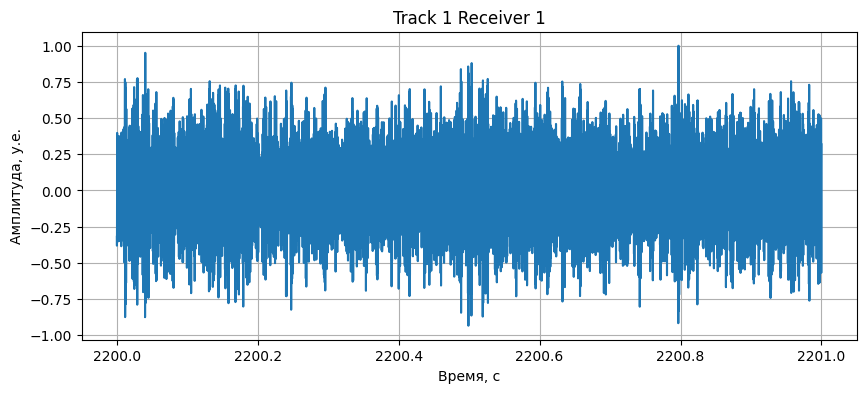

Максимум по амплитуде: 1.0
Время максимума: 2200.7971201814057 с.


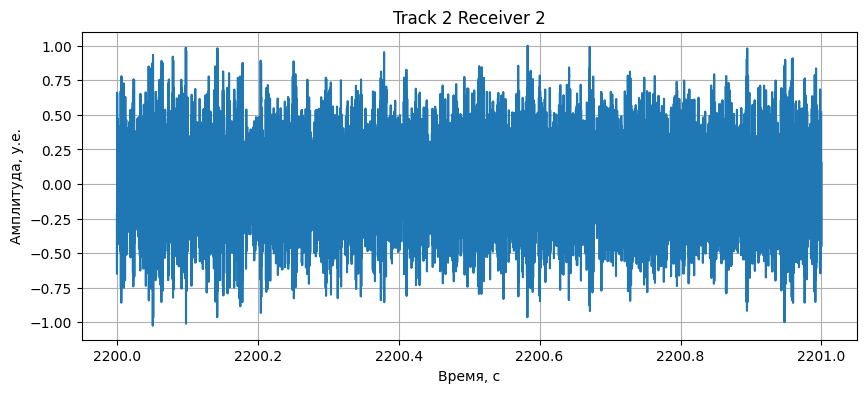

Максимум по амплитуде: 1.0
Время максимума: 2200.582970521542 с.


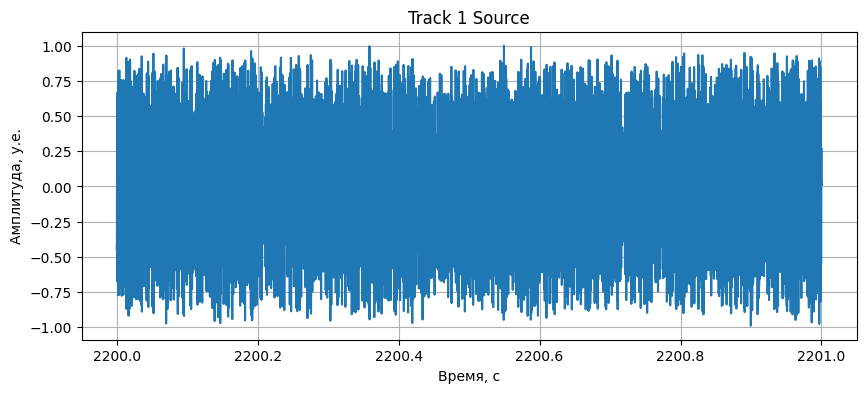

Максимум по амплитуде: 1.0
Время максимума: 2200.549387755102 с.


In [6]:
df_cut = plot_cut(borders=[2200, 2201], number=3, df=df, plots=True)

**Строим корреляции и огибающие, а после усредняем**:

Text(0, 0.5, 'Amp')

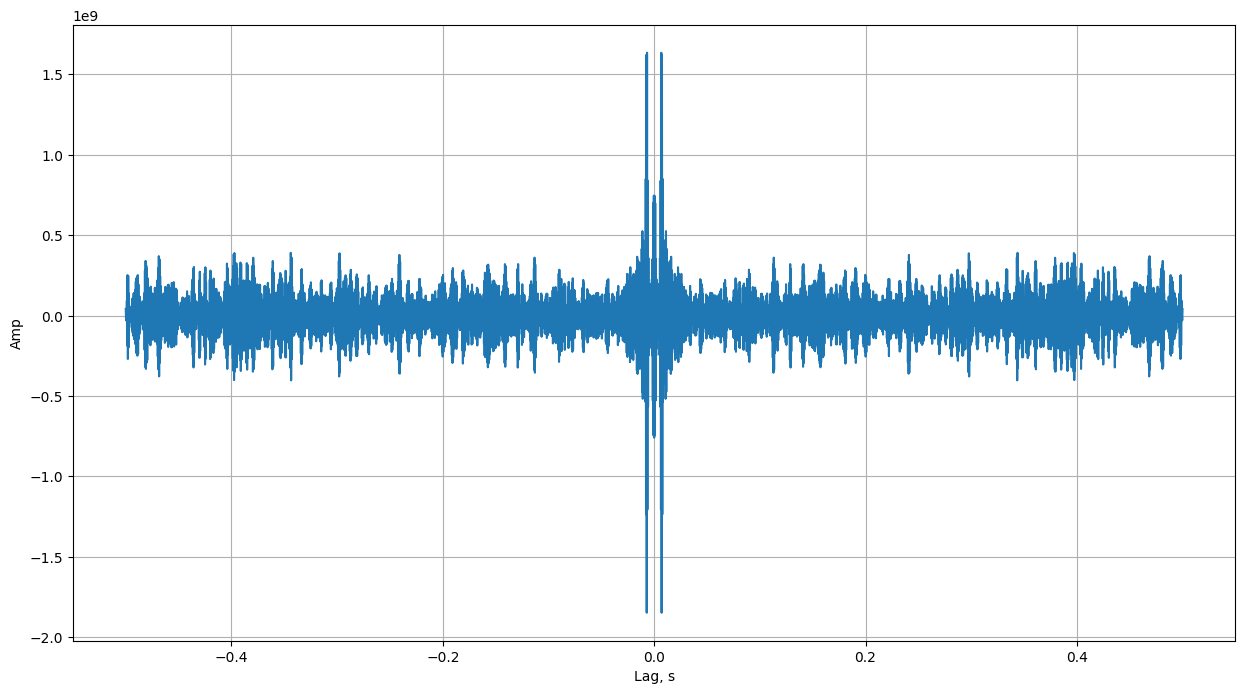

In [10]:
corr, lags = corr_f(df_cut['data'][1], df_cut['data'][2], 44100, filter_freq=4000, do_filter=True)

plt.figure(figsize=(15, 8))
plt.plot(lags, corr)
plt.grid()

plt.xlabel('Lag, s')
plt.ylabel('Amp')

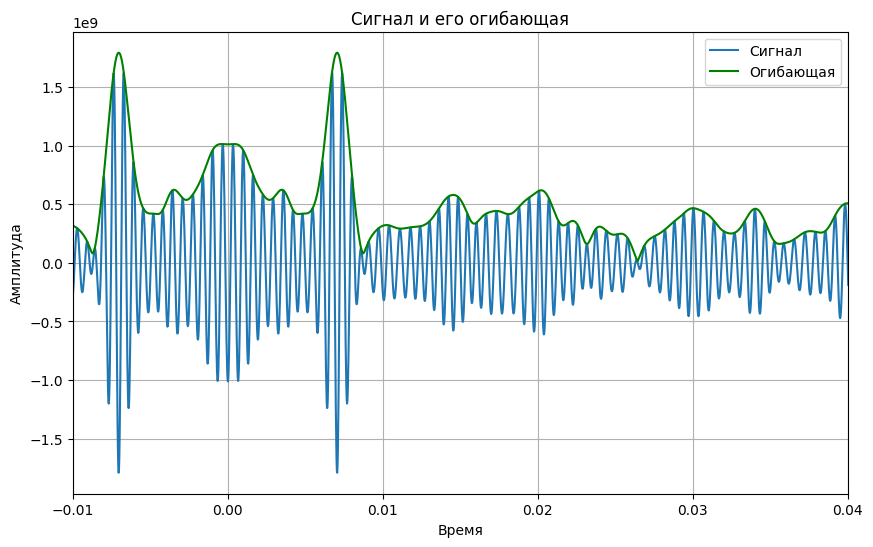

In [5]:
analytic_signal = hilbert(np.real(corr))
envelope = np.abs(analytic_signal)

plt.figure(figsize=(10, 6))
plt.plot(lags, corr, label="Сигнал")
plt.plot(lags, envelope, label="Огибающая", color="green")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Сигнал и его огибающая")
plt.legend()
plt.xlim([-0.01, 0.04])
plt.grid()
plt.show()

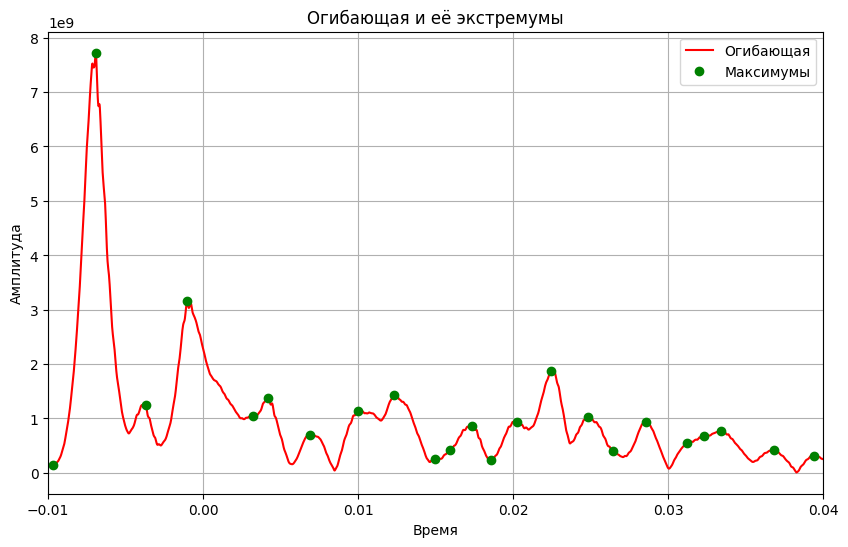

In [20]:
peaks, _ = find_peaks(envelope, distance=40)

plt.figure(figsize=(10, 6))
plt.plot(lags, envelope, label="Огибающая", color="red")
plt.plot(lags[peaks], envelope[peaks], "go", label="Максимумы")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Огибающая и её экстремумы")
plt.xlim([-0.01, 0.04])
plt.legend()
plt.grid()
plt.show()

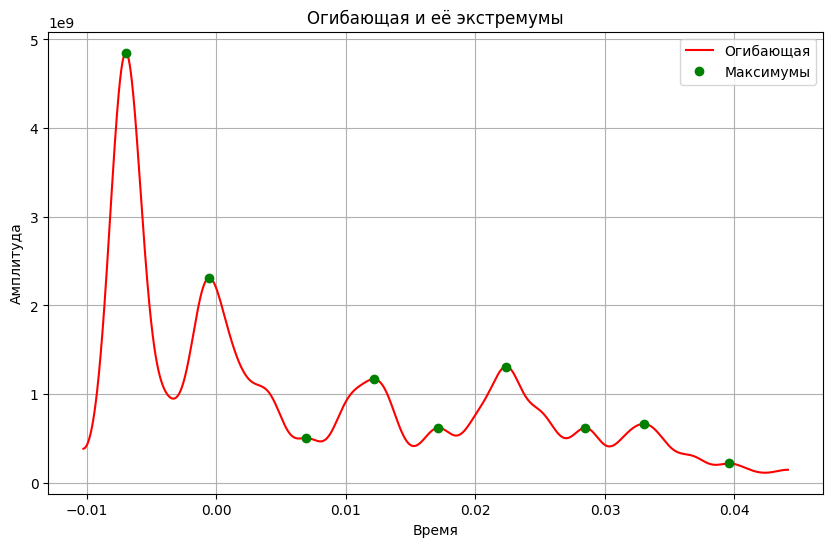

In [42]:
corr_ = corr[10600:13000]
lags_ = lags[10600:13000]
envelope_ = envelope[10600:13000]
envelope_ = gaussian_filter1d(envelope_, sigma=40)

peaks_, _ = find_peaks(envelope_, distance=40)

plt.figure(figsize=(10, 6))
plt.plot(lags_, envelope_, label="Огибающая", color="red")
plt.plot(lags_[peaks_], envelope_[peaks_], "go", label="Максимумы")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Огибающая и её экстремумы")
plt.legend()
plt.grid()
plt.show()

In [43]:
t1, t2, t3 = find_delta_time(corr, lags)

In [47]:
t2

np.float64(-0.000997732426303855)

In [9]:
whole_signal = np.linspace(2000.0, 2200.0, 400)

In [35]:
arr_times = []

for i in range(1,len(whole_signal)):
    df_cut = plot_cut(borders=[whole_signal[i-1], whole_signal[i]], number=3, df=df, plots=False)
    corr, lags = corr_f(df_cut['data'][1], df_cut['data'][2], 44100, filter_freq=200, do_filter=False)
    t1, t2, t3 = find_delta_time(corr, lags)
    
    arr_times.append(t2-t3)

In [36]:
print(f'Среднее значение времени: {np.mean(arr_times)} c')
print(f'Стандартное отклонение значений времени: {np.sqrt(np.var(arr_times))} c')

Среднее значение времени: 0.006097215828687365 c
Стандартное отклонение значений времени: 0.0031564561679786386 c


Гильбертово преобразование. Оценить время прихода первого пика и т.д.
По много отрезков берём и усредняем огиб.
Поверх другим цветом. При увеличении времени меняется. +-4 м глубина, дно 12 м.

Посмотреть на других глубинах. Должны сместиться

расстояния между гидрофонами?
глубина погружения первого?

взаимная корр му 2 пр сдвиг по времени (отразился от лодки пришел на 1 потом на 2) отразился от дна пришел на 1 потом на 2

Информация о конц пузырьков по коэф отр?

уср функций, уср abs, уср огиб (по реализациям)

посмотреть частотный диапазон с энергией (от 200Гц до 4 кГц)

коэф отражения от частоты (и угла падения) - ? изменение амплитуды от взаимодействия с дном + сфер волна (1/r)

SPEKTR


**Построим корреляцию:**

**Много маленьких и усреднить + все сразу выводить. Много корреляций по 1/30 с и идем по времени. А потом усредняем. Еще вариант брать abs и складывать**

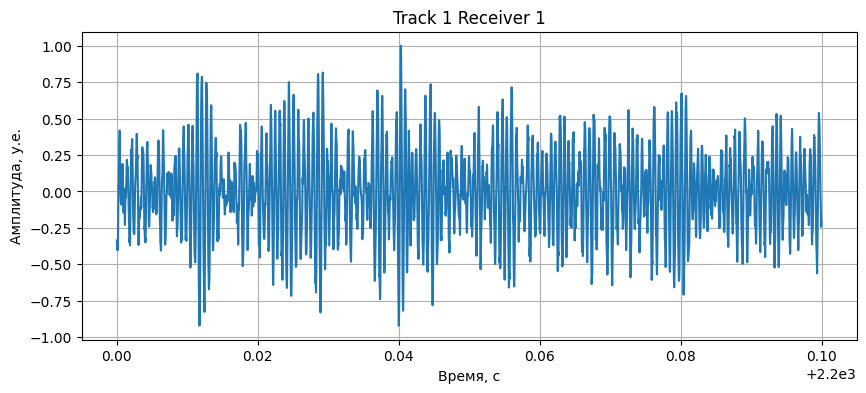

Максимум по амплитуде: 1.0
Время максимума: 2200.0402947845805 с.


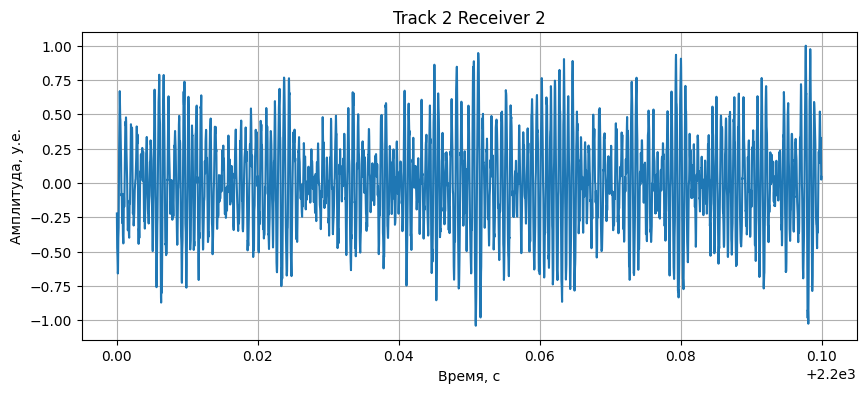

Максимум по амплитуде: 1.0
Время максимума: 2200.097755102041 с.


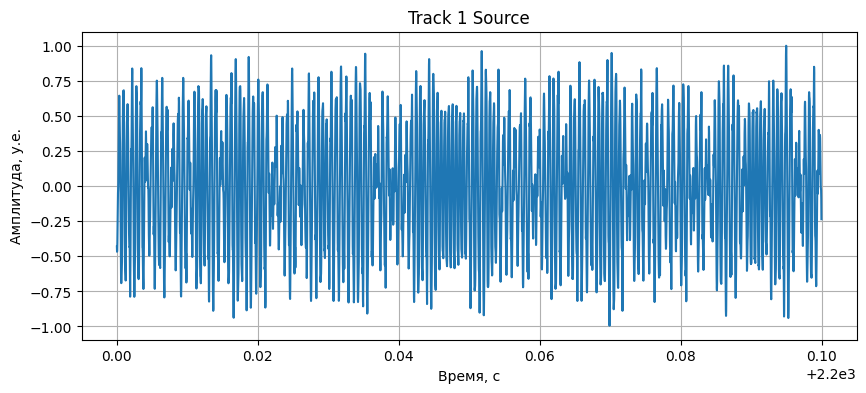

Максимум по амплитуде: 1.0
Время максимума: 2200.0949659863945 с.


Text(0, 0.5, 'Amp')

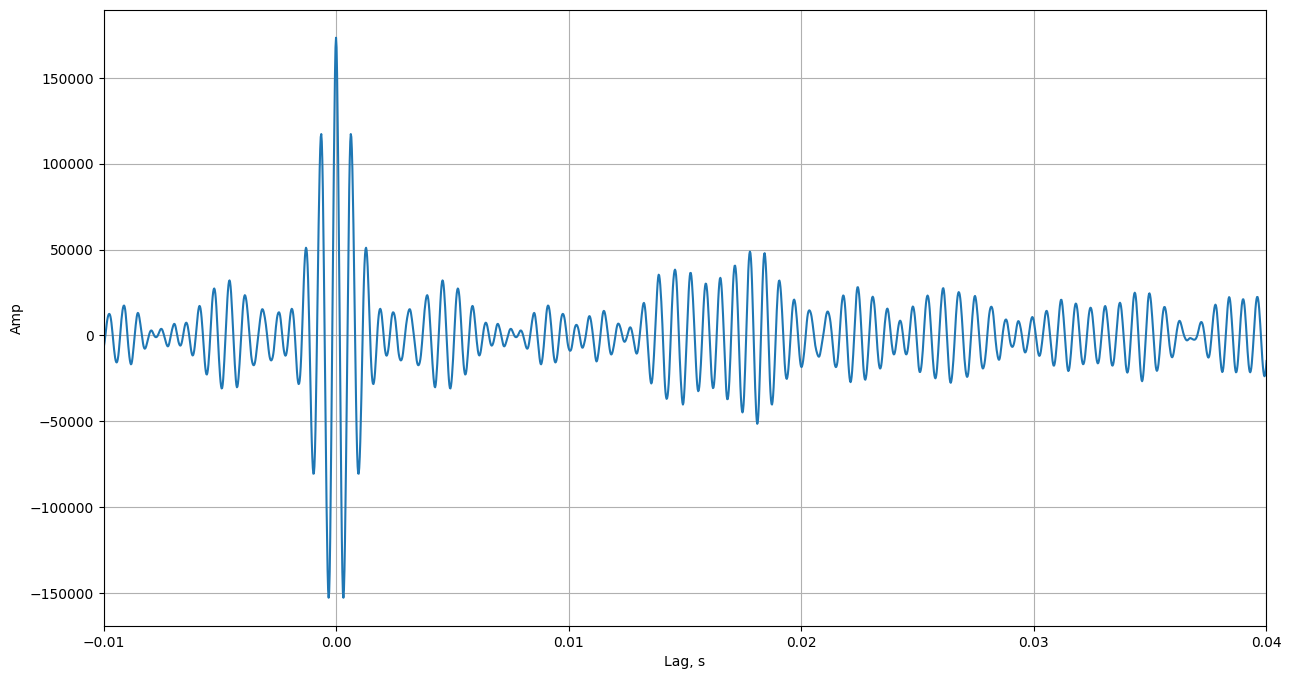

In [51]:
df_cut = plot_cut(borders=[2200, 2200.1], number=3, df=df, plots=True)
corr, lags = corr_f(df_cut['data'][2], df_cut['data'][2], 44100, filter_freq=200, do_filter=False)

plt.figure(figsize=(15, 8))
plt.plot(lags, corr)
plt.grid()
plt.xlim([-0.01, 0.04])
plt.xlabel('Lag, s')
plt.ylabel('Amp')

Добавляем вывод спектра сигнала + фильтрация

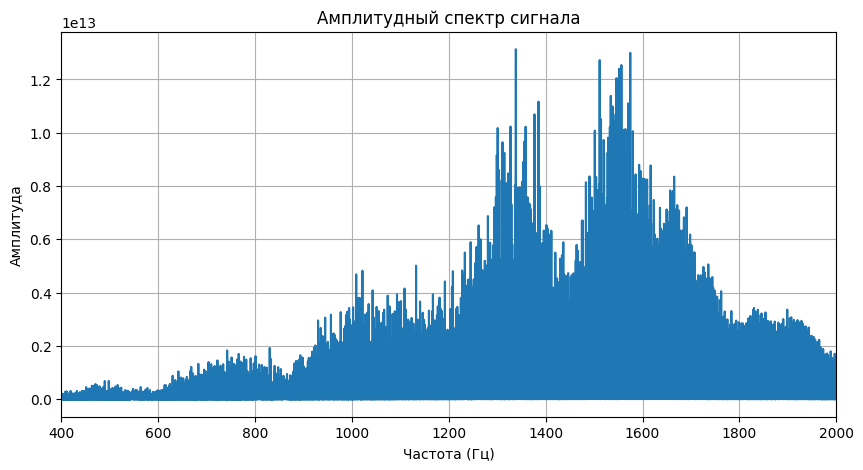

In [12]:
T = 1.0 / 44100
N = len(df_cut['time'][1])
spectrum = np.fft.fft(df_cut['data'][1])
spectrum = np.abs(spectrum[:N // 2])
freq = np.fft.fftfreq(N, T)[:N // 2]

plt.figure(figsize=(10, 5))
plt.plot(freq, spectrum)
plt.xlabel("Частота (Гц)")
plt.ylabel("Амплитуда")
plt.title("Амплитудный спектр сигнала")
plt.xlim([400, 2000])
plt.grid()
plt.show()